<a href="https://colab.research.google.com/github/micheldc55/Deep-Learning/blob/main/PyTorch_classification_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Exercise

1. Make a binary classification dataset with Scikit-Learn's make_moons() function.
  * For consistency, the dataset should have 1000 samples and a random_state=42.
  * Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

3. Setup a binary classification compatible loss function and optimizer to use when training the model.
4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.
5. Make predictions with your trained model and plot the decision boundary.

In [1]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sklearn.datasets
import sklearn.model_selection
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics

In [3]:
X_base, y_base = sklearn.datasets.make_moons(n_samples=1000, random_state=42)

In [4]:
X_base.shape

(1000, 2)

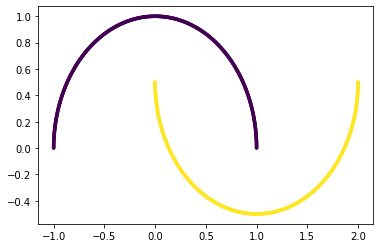

In [5]:
plt.scatter(X_base[:, 0], X_base[:, 1], c=y_base, s=7)

In [6]:
X = torch.from_numpy(X_base).type(torch.float)
y = torch.from_numpy(y_base).type(torch.float)
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

## Splitting:

In [7]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

## Creating a model

In [9]:
num_features = X_train.shape[1]

In [10]:
class BinaryClassification(torch.nn.Module):
  def __init__(self, neurons: int):
    super().__init__()
    self.model = torch.nn.Sequential(
        torch.nn.Linear(in_features=num_features, out_features=neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=neurons, out_features=neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=neurons, out_features=1)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.model(x)

In [11]:
model = BinaryClassification(neurons=8)

## Loss function and Optimizer

It's a binary classification problem, so binary cross entropy is a good choice. Also will be using the loss that takes the logits as inputs, as it is more stable according to the documentation.

In [12]:
loss_fn = torch.nn.BCEWithLogitsLoss()

lr = 0.01
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

## Training Loop

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

BinaryClassification(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [14]:
accuracy = torchmetrics.Accuracy('binary')

In [15]:
y_train.shape

torch.Size([800])

In [16]:
def train_model(
    model, X_train, X_test, y_train, y_test, 
    device, metric, loss_fn, optimizer
):
  """Trains model. Model must be in the same device as the data."""
  model.train()

  X_train, X_test = X_train.to(device), X_test.to(device)
  y_train, y_test = y_train.to(device), y_test.to(device)

  # Forward pass
  logits_train = model(X_train).squeeze()
  predictions_train = torch.sigmoid(logits_train)

  # Loss function
  loss_train = loss_fn(logits_train, y_train)
  metric_train = metric(predictions_train, y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation Calculation
  loss_train.backward()

  # Optimization step (gradient descent)
  optimizer.step()

  # Testing on validation:
  model.eval()

  with torch.inference_mode():
    logits_test = model(X_test).squeeze()
    predictions_test = torch.sigmoid(logits_test)
    loss_test = loss_fn(logits_test, y_test)
    metric_test = metric(predictions_test, y_test)

  return loss_train.item(), loss_test.item(), metric_train, metric_test #, model

In [17]:
def plot_loss(train_loss, test_loss, epoch_counts: int, metric_train=None, metric_test=None):
  n_rows, n_cols, figsize = 1, 2, (12, 6)

  fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)

  ax[0].plot(epoch_counts, train_loss, label='Train Loss')
  ax[0].plot(epoch_counts, test_loss, label='Test Loss')
  ax[0].set_title('Train/Test Loss')
  ax[0].legend()

  ax[1].plot(epoch_counts, metric_train, label='Train Accuracy')
  ax[1].plot(epoch_counts, metric_test, label='Test Accuracy')
  ax[1].set_title('Train/Test Accuracy')
  ax[1].legend()

In [18]:
epochs = 250

epoch_counts     = []
acc_loss_train   = []
acc_loss_test    = []
acc_train_metric = []
acc_test_metric  = []

for epoch in range(1, epochs+1):
  loss_train, loss_test, metric_train, metric_test = train_model(
      model, X_train, X_test, y_train, y_test, 
      device, accuracy, loss_fn, optimizer
  )

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Train Loss: {loss_train} | Test Loss: {loss_test} | Accuracy Train: {metric_train} | Accuracy Test: {metric_test}')

    acc_loss_train.append(loss_train)
    acc_loss_test.append(loss_test)
    acc_train_metric.append(metric_train)
    acc_test_metric.append(metric_test)
    epoch_counts.append(epoch)

Epoch: 10 | Train Loss: 0.6455860733985901 | Test Loss: 0.6433805227279663 | Accuracy Train: 0.6537500023841858 | Accuracy Test: 0.7099999785423279
Epoch: 20 | Train Loss: 0.5228368639945984 | Test Loss: 0.5295072793960571 | Accuracy Train: 0.7524999976158142 | Accuracy Test: 0.675000011920929
Epoch: 30 | Train Loss: 0.3975359797477722 | Test Loss: 0.4133247137069702 | Accuracy Train: 0.7975000143051147 | Accuracy Test: 0.7450000047683716
Epoch: 40 | Train Loss: 0.31955233216285706 | Test Loss: 0.33542293310165405 | Accuracy Train: 0.8337500095367432 | Accuracy Test: 0.7799999713897705
Epoch: 50 | Train Loss: 0.2531939744949341 | Test Loss: 0.2630520761013031 | Accuracy Train: 0.8712499737739563 | Accuracy Test: 0.9049999713897705
Epoch: 60 | Train Loss: 0.19658367335796356 | Test Loss: 0.2024509757757187 | Accuracy Train: 0.9212499856948853 | Accuracy Test: 0.925000011920929
Epoch: 70 | Train Loss: 0.14675602316856384 | Test Loss: 0.15001359581947327 | Accuracy Train: 0.94499999284744

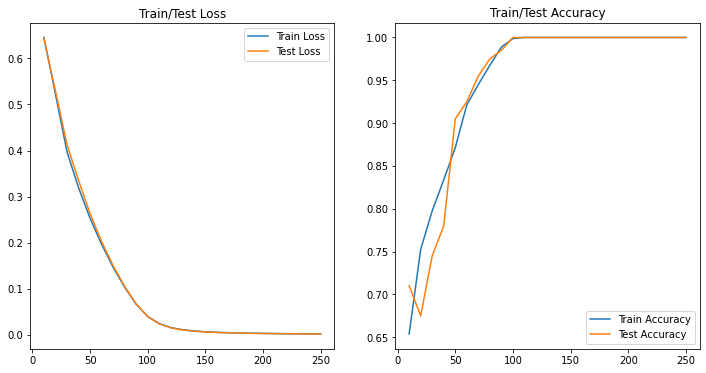

In [19]:
plot_loss(acc_loss_train, acc_loss_test, epoch_counts, acc_train_metric, acc_test_metric)

## Plotting the model's decision boundary

In [20]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

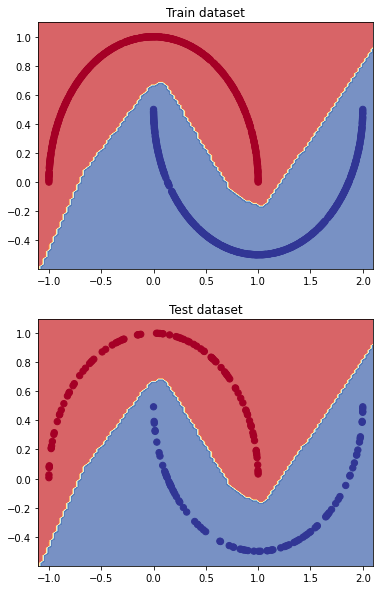

In [21]:
plt.figure(figsize=(6, 10))

plt.subplot(2, 1, 1)
plt.title("Train dataset")
plot_decision_boundary(model, X_train, y_train)

plt.subplot(2, 1, 2)
plt.title("Test dataset")
plot_decision_boundary(model, X_test, y_test)

### 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch

In [22]:
def pytorch_tanh(x: torch.Tensor) -> torch.Tensor:
  tanh = (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
  return tanh

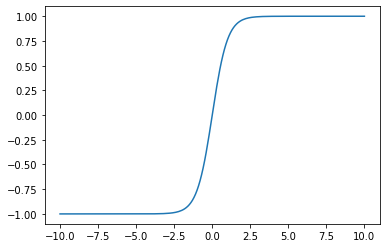

In [23]:
x = torch.arange(-10, 10.1, 0.1)
y = pytorch_tanh(x)

plt.plot(x, y)

## 7. Create a multi-class model for the spirals dataset

### Generating the data

In [24]:
def generate_spirals(N, D, K):
  # Code for creating a spiral dataset from CS231n
  X = np.zeros((N*K,D)) # data matrix (each row = single example)
  y = np.zeros(N*K, dtype='uint8') # class labels
  for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
  # lets visualize the data
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
  plt.show()

  return X, y

In [25]:
  N = 400 # number of points per class
  D = 2 # dimensionality
  K = 3 # number of classes

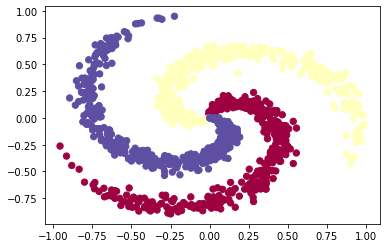

In [26]:
X, y = generate_spirals(N, D, K)

### Splitting the Data

In [27]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((960, 2), (960,), (240, 2), (240,))

### Converting data to tensors

In [29]:
X_train = torch.from_numpy(X_train).type(torch.float)
X_test  = torch.from_numpy(X_test).type(torch.float)

y_train = torch.from_numpy(y_train).type(torch.float)
y_test  = torch.from_numpy(y_test).type(torch.float)

### Building the multi-class model

In [30]:
class MultiClassModel(torch.nn.Module):
  def __init__(self, neurons, n_features, n_classes):
    super().__init__()
    self.model = torch.nn.Sequential(
        torch.nn.Linear(in_features=n_features, out_features=neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=neurons, out_features=neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=neurons, out_features=n_classes)
    )
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.model(x)

model = MultiClassModel(neurons=8, n_features=D, n_classes=K)

In [31]:
loss_fn = torch.nn.CrossEntropyLoss()

lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Testing the model

In [39]:
model.eval()

with torch.inference_mode():
  meaningless_logits = model(X_train)
  meaningless_pred_probs  = torch.softmax(meaningless_logits, dim=1)
  meaningless_predictions = torch.argmax(meaningless_pred_probs, dim=1)

torch.sum(meaningless_pred_probs[:10], dim=1), meaningless_predictions[:10]

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]), tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [41]:
meaningless_pred_probs[:10]

tensor([[0.3594, 0.2721, 0.3686],
        [0.3539, 0.2622, 0.3838],
        [0.3491, 0.2720, 0.3789],
        [0.3481, 0.2694, 0.3825],
        [0.3399, 0.2874, 0.3727],
        [0.3642, 0.2476, 0.3882],
        [0.3402, 0.2875, 0.3723],
        [0.3474, 0.2670, 0.3856],
        [0.3485, 0.2727, 0.3788],
        [0.3403, 0.2870, 0.3727]])

## Defining the training loop

In [47]:
K  # Number of classes

3

In [48]:
accuracy_multiclass = torchmetrics.Accuracy('multiclass', num_classes=K)

In [42]:
def train_multi_class_model(
    model, X_train, X_test, y_train, y_test, 
    device, metric, loss_fn, optimizer
):
  """Trains model. Model must be in the same device as the data."""
  model.train()

  X_train, X_test = X_train.to(device), X_test.to(device)
  y_train, y_test = y_train.to(device), y_test.to(device)

  # Forward pass
  logits_train = model(X_train)
  predictions_train = torch.softmax(logits_train, dim=1).argmax(dim=1)

  # Loss function
  loss_train = loss_fn(logits_train, y_train)
  metric_train = metric(predictions_train, y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation Calculation
  loss_train.backward()

  # Optimization step (gradient descent)
  optimizer.step()

  # Testing on validation:
  model.eval()

  with torch.inference_mode():
    logits_test = model(X_test)
    predictions_test = torch.softmax(logits_test, dim=1).argmax(dim=1)
    loss_test = loss_fn(logits_test, y_test)
    metric_test = metric(predictions_test, y_test)

  return loss_train.item(), loss_test.item(), metric_train.item(), metric_test.item()

In [49]:
train_multi_class_model(
    model=model, X_train=X_train, X_test=X_test, y_train=y_train.type(torch.LongTensor), 
    y_test=y_test.type(torch.LongTensor), device=device, 
    metric=accuracy_multiclass, loss_fn=loss_fn, optimizer=optimizer
)

(1.098750352859497, 1.0776702165603638, tensor(0.3333), tensor(0.3792))

torch.float32

In [51]:
epochs = 250

epoch_counts     = []
acc_loss_train   = []
acc_loss_test    = []
acc_train_metric = []
acc_test_metric  = []

for epoch in range(1, epochs+1):
  loss_train, loss_test, metric_train, metric_test = train_multi_class_model(
    model=model, X_train=X_train, X_test=X_test, 
    y_train=y_train.type(torch.LongTensor), 
    y_test=y_test.type(torch.LongTensor), device=device, 
    metric=accuracy_multiclass, loss_fn=loss_fn, optimizer=optimizer
)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Train Loss: {loss_train} | Test Loss: {loss_test} | Accuracy Train: {metric_train} | Accuracy Test: {metric_test}')

    acc_loss_train.append(loss_train)
    acc_loss_test.append(loss_test)
    acc_train_metric.append(metric_train)
    acc_test_metric.append(metric_test)
    epoch_counts.append(epoch)

Epoch: 10 | Train Loss: 0.18199491500854492 | Test Loss: 0.15789394080638885 | Accuracy Train: 0.9229166507720947 | Accuracy Test: 0.9333333373069763
Epoch: 20 | Train Loss: 0.16957823932170868 | Test Loss: 0.14243847131729126 | Accuracy Train: 0.9291666746139526 | Accuracy Test: 0.9458333253860474
Epoch: 30 | Train Loss: 0.1583804190158844 | Test Loss: 0.13206274807453156 | Accuracy Train: 0.9385416507720947 | Accuracy Test: 0.9666666388511658
Epoch: 40 | Train Loss: 0.14632298052310944 | Test Loss: 0.1211690604686737 | Accuracy Train: 0.9437500238418579 | Accuracy Test: 0.9666666388511658
Epoch: 50 | Train Loss: 0.13224497437477112 | Test Loss: 0.10834986716508865 | Accuracy Train: 0.9489583373069763 | Accuracy Test: 0.9708333611488342


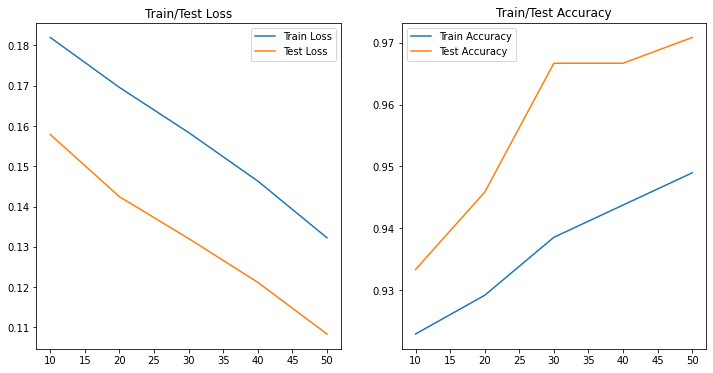

In [52]:
plot_loss(acc_loss_train, acc_loss_test, epoch_counts, acc_train_metric, acc_test_metric)

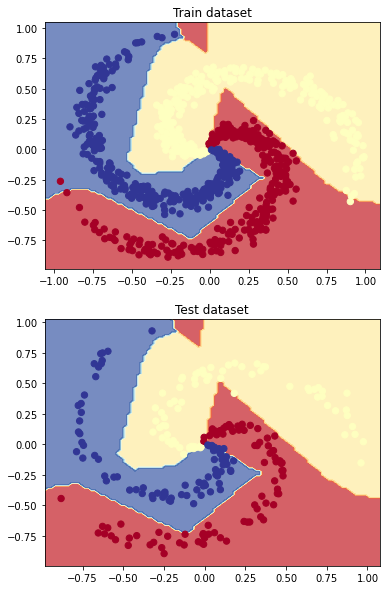

In [53]:
plt.figure(figsize=(6, 10))

plt.subplot(2, 1, 1)
plt.title("Train dataset")
plot_decision_boundary(model, X_train, y_train)

plt.subplot(2, 1, 2)
plt.title("Test dataset")
plot_decision_boundary(model, X_test, y_test)